# Chapter 3. Classification

## Definitions

- skewed dataset: in a classification problem, when some classes are much more frequent than others

- clean prediction: prediction for which the estimator was not directly trained on.

## MNIST (Modified National Institute of Standards and Technology Database)

Set of 70000 small images of digits handwritten by high school students and employees of the US census bureau. Each image is labeled with the digit it represents.

In [4]:
# import MNIST from sklearn
# takes around 1 minute!
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by sklearn usually have a dict-like structure with the following fields at least:
- DESCR key describes the dataset
- data, 2-D array of features
- target, array with the labels

In [5]:
type(mnist)

sklearn.utils.Bunch

In [6]:
type(mnist["target"])  # it's a pandas Series!

pandas.core.series.Series

In [7]:
type(mnist["data"])  # it's a pandas Df!

pandas.core.frame.DataFrame

In [8]:
mnist["DESCR"]

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

Since the book assumes that X and y are numpy arrays, let's cat them into that type (in current version they are Pandas objects)

In [10]:
X = mnist["data"].values
y = mnist["target"].values
X.shape, y.shape

((70000, 784), (70000,))

We see we have indeed 70000 observations. In terms of features, there are 784, each of them representing a pixel in a 28 x 28 image. The original data has columns, so we can have a check:

In [11]:
mnist["data"].columns

Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784)

Let's explore the first values of X and y:

In [12]:
X[:5], y[:5]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 ['5', '0', '4', '1', '9']
 Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9'])

we notice that y is a categorical array. For our purposes, we need to conver it into numeric values:

In [13]:
import numpy as np
y = y.astype(np.uint8)

(-0.5, 27.5, 27.5, -0.5)

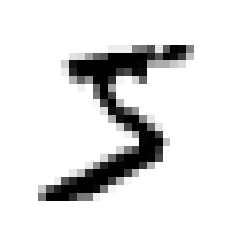

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")

Let's put this into a function:

This number's label is 3


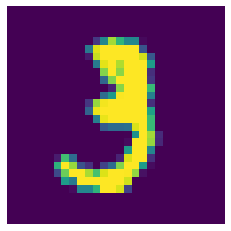

In [16]:
def visualise_digit_number(X, n):
    some_digit = X[n]
    some_digit_image = some_digit.reshape(28, 28)

    plt.imshow(some_digit_image)
    plt.axis("off")
    print("This number's label is", y[n])

visualise_digit_number(X, 10)

The MNIST dataset is already split into a training (the first 60000 observations) and test dataset (the rest). The training set is already shuffled, so that we have all digits in every fold (in practice, we would need to check that!)

In [19]:
TRAINING = slice(60000)
TEST = slice(60000, None)

In [20]:
X_train, X_test, y_train, y_test = X[TRAINING], X[TEST], y[TRAINING], y[TEST]

In [21]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

## Binary Classification

Let's train a 5-detector.

In [22]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [23]:
y_train_5[:6]

array([ True, False, False, False, False, False])

In [24]:
# Stochastic Gradient Descent classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [25]:
sgd_clf.predict([some_digit])

array([ True])

### Evaluate Performance

Measuring accuracy using cross-validation.

In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Nice! Over 95 % of accuracy on all cross-validation folds! Well, this is a bit of a mirage. Let's create a dumb classifier that classifies every image as a "not-5":

In [27]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [28]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Ok, so even this dumb classifier can get over 90 % accuracy in our sample! This demonstrates why accuracy is not preferred as a performance metric when dealing with *skewed datasets*.

#### Confusion Matrix

A confusion matrix has the true values in its rows, the classified values in its columns. For example, to check how many 5s were classified as 3s, we would check the 5th row and 3rd column.

We introduce a new tool now, the `cross_val_predict` function. It performs K-fold cross-validation, but instead of returning a score for each fold, it computes the predictions for each. This means that we get a *clean* prediction for each instance in the training set (*clean* meaning that the model never saw the predicted data during training).

In [29]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [30]:
# we get a single array with all predictions! :)
y_train_pred.shape

(60000,)

Now we can compute the confusion matrix

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Let's interpret this matrix reading row after row:
- 53892 non-fives were correctly interpreted as such, while 687 were classified as fives
- 3530 fives were classified as fives, while 1891 were not.

#### Summarising the confusion matrix. Recall and Precision

$$Precision = \frac{TP}{TP + FP}$$

To put it in words, of all observations classified as a five, how many were actually a five? Likewise, we need to read the column of the confusion matrix. In the previous example, 

In [32]:
precision = 3530 / (3530 + 687)
precision

0.8370879772350012

$$Recall = \frac{TP}{TP + FN}$$

To put it in words, of all fives in the dataset, how many were classified as such? We need to read the row of the confusion matrix. In the previous example,

In [33]:
recall = 3530 / (3530 + 1891)
recall

0.6511713705958311

Sklearn provides convenience functions to compute them:

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [35]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [36]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

What is the F1 score? it's just the harmonic mean of recall and precision. the harmonic mean has the nice property that to be high, all values must be high.

$$\text{F1-score} = \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}}$$

Exercise. What do you prefer, high recall or precision?

- Safe videos for kids
    - You don't want to say something is safe when is not. So you want a high precision, i.e. when you claim that something is safe, it is safe
    - the shortcoming is that some safe videos will be classified as unsafe
- Shoplifters in survaillance videos
    - You don't want to miss a shoplifer (TP). So we need to detect all shoplifters in the sample, i.e. having a high recall
    - the shortcoming is that you'll get some false alerts

The shortcomings mentioned are examples of the *Precision/Recall trade-off*

# Multiclass Classification

There are some classifiers that can handle multiple classes natively, such as the Logistic Regression classifiers and the Random Forest classifiers.

Others, such as SGD Classifiers or Support Vector Machines, are strictly binary. To deal with them, we have two strategies:

- One versus the Rest (OvR): train a classifier for each class, choose the class with the highest score
- One versus One (OvO): train all possible duels, see which class wins more duels. This is very expensive computationally, but for some classifiers that don't scale well, such as SVMs

Sklearn automatically chooses the strategy that is more adequate for the algorithm you have chosen. Let's try the SVM classifier, for example:

In [37]:
# takes several minutes to run!
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Apparently easy, right? Well, under the hood, `sklearn` uses the OvO strategy.

If we call the `decision_function` method for this classifier, you will see it returns 10 scores per instance. This is one score per class, where each score is the number of won duels plus a small tweak to break ties based on the binary classifier scores.

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

Note that the highest score indeed corresponds to class 5.

In [42]:
svm_clf.classes_[np.argmax(some_digit_scores)]

5

To transform a OvO classifier into an OvR, you can do the following:

In [49]:
from sklearn.multiclass import OneVsRestClassifier

In [50]:
ovr_clf = OneVsRestClassifier(SVC())

In [45]:
# long time to run!!
ovr_clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
ovr_clf.predict([some_digit])

To verify which strategy we're using, we can get the `estimators_` attribute

In [ ]:
len(ovr_clf.estimators_)

To evaluate the classifier, we can use `cross_val_score` as usual

In [59]:
cross_val_score(ovr_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=10, n_jobs=3)  # returns scores on each fold

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 21.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 21.7min finished


array([0.97685, 0.9738 , 0.97495])

Compared to a random classifier, which would get 10 %. Scaling the inputs, we can do even better!

## Plotting confusion matrices

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=5)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [ ]:
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The confusion matrix looks good. Maybe the classifier works slightly worse for 5s. Let's analyse the errors. To do that, we compute error rates:

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

In [ ]:
norm_conf_mx = conf_mx / row_sums

Now we fill the diagonal with zeros (to keep only the errors), and we plot again:

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)  # edits in place
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Remember that rows represent actual classes, columns predicted classes. It is quite clear that the column for 8s is lighter than the rest, i.e. that we predict too many false 8s. Possible strategies:
- Gather more training data for digits that look like 8s, but are not
- Engineer new features, such as a classifier that counts the number of closed loops
- Preprocess the images to make some patterns, such as closed loops, stand out more